# 2018-05-15 - Vers le ring - Version CUDA
Il existe une implémentation PyTorch des network d'elman, [torch.nn.rnn](https://pytorch.org/docs/master/_modules/torch/nn/modules/rnn.html).

## LSTM for MNIST classification
On va commencer par jouer avec MNIST sur un RNN bidirectionnel pour voir ce que ça donne :

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.003

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0).cuda()
        c0 = Variable(c0).cuda()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size)).cuda()
        labels = Variable(labels).cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Processing...
Done!
Start training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/2], Step [100/600], Loss: 0.6337
Epoch [1/2], Step [200/600], Loss: 0.2936
Epoch [1/2], Step [300/600], Loss: 0.3494
Epoch [1/2], Step [400/600], Loss: 0.2044
Epoch [1/2], Step [500/600], Loss: 0.1254
Epoch [1/2], Step [600/600], Loss: 0.0257
Epoch [2/2], Step [100/600], Loss: 0.1751
Epoch [2/2], Step [200/600], Loss: 0.0528
Epoch [2/2], Step [300/600], Loss: 0.0866
Epoch [2/2], Step [400/600], Loss: 0.0275
Epoch [2/2], Step [500/600], Loss: 0.0304
Epoch [2/2], Step [600/600], Loss: 0.0713


In [7]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size)).cuda()
    labels = Variable(labels).cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 97.89 %


On plot :

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MNIST-RNN')
plt.show()

# LSTM for MC Classification
On passe à la partie qui nous intéresse. Commençons par importer les données :

In [3]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

On défini les hyper-param du réseau :

In [4]:
# Hyper-parameters
sequence_length = 64
input_size = 64
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 8
num_epochs = 2
learning_rate = 0.003

Et on défini le RNN bidirectionnel :

In [6]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0).cuda()
        c0 = Variable(c0).cuda()

        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # LSTM output
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()
print(model)

BiRNN(
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=16, bias=True)
)


Cette fois-ci on est toujours en CEL mais l'Adam est plus adapté, donc il faut baisser le learning rate d'un facteur dix dans les hyper-parameters au-dessus :

In [7]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Et on train :

In [8]:
#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size)).cuda()
        labels = Variable(labels).cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Start training
Epoch [1/2], Step [100/480], Loss: 2.8184
Epoch [1/2], Step [200/480], Loss: 2.7843
Epoch [1/2], Step [300/480], Loss: 2.3345
Epoch [1/2], Step [400/480], Loss: 2.6726
Epoch [2/2], Step [100/480], Loss: 2.8039
Epoch [2/2], Step [200/480], Loss: 2.3290
Epoch [2/2], Step [300/480], Loss: 2.8367
Epoch [2/2], Step [400/480], Loss: 2.4442


Et on teste :

In [38]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size)).cuda()
    labels = Variable(labels).cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 


Test Accuracy of the model on the 10000 test images: 6.25 %


# RNN for MNIST classification

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 20
learning_rate = 0.003

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).cuda() # 2 for bidirection 
        h0 = Variable(h0).cuda()

        # Forward propagate LSTM
        out, _ = self.lstm(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size)).cuda()
        labels = Variable(labels).cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Start training
Epoch [1/20], Step [100/600], Loss: 0.8855
Epoch [1/20], Step [200/600], Loss: 0.7461
Epoch [1/20], Step [300/600], Loss: 0.5349
Epoch [1/20], Step [400/600], Loss: 0.4185
Epoch [1/20], Step [500/600], Loss: 0.2822
Epoch [1/20], Step [600/600], Loss: 0.4086
Epoch [2/20], Step [100/600], Loss: 0.4656
Epoch [2/20], Step [200/600], Loss: 0.3021
Epoch [2/20], Step [300/600], Loss: 0.3520
Epoch [2/20], Step [400/600], Loss: 0.1446
Epoch [2/20], Step [500/600], Loss: 0.4760
Epoch [2/20], Step [600/600], Loss: 0.2025
Epoch [3/20], Step [100/600], Loss: 0.2343
Epoch [3/20], Step [200/600], Loss: 0.3364
Epoch [3/20], Step [300/600], Loss: 0.3917
Epoch [3/20], Step [400/600], Loss: 0.3212
Epoch [3/20], Step [500/600], Loss: 0.2996
Epoch [3/20], Step [600/600], Loss: 0.2541
Epoch [4/20], Step [100/600], Loss: 0.1909
Epoch [4/20], Step [200/600], Loss: 0.2411
Epoch [4/20], Step [300/600], Loss: 0.3053
Epoch [4/20], Step [400/600], Loss: 0.2162
Epoch [4/20], Step [500/600], Loss: 0.1

KeyboardInterrupt: 

Test Accuracy of the model on the 10000 test images: 93.67 %


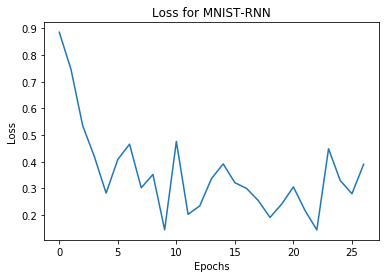

In [10]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size)).cuda()
    labels = Variable(labels).cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MNIST-RNN')
plt.show()

# RNN for MC classification

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets



#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=False,
                                             num_workers=1)

# Hyper-parameters
sequence_length = 64
input_size = 64
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 100
num_epochs = 5
learning_rate = 0.003

# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).cuda() # 2 for bidirection 
        h0 = Variable(h0).cuda()

        # Forward propagate LSTM
        out, _ = self.lstm(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes).cuda()


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size)).cuda()
        labels = Variable(labels).cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Start training
Epoch [1/5], Step [100/480], Loss: 2.8456
Epoch [1/5], Step [200/480], Loss: 2.9674
Epoch [1/5], Step [300/480], Loss: 2.5428
Epoch [1/5], Step [400/480], Loss: 2.7434
Epoch [2/5], Step [100/480], Loss: 3.2448
Epoch [2/5], Step [200/480], Loss: 2.9117
Epoch [2/5], Step [300/480], Loss: 2.7860
Epoch [2/5], Step [400/480], Loss: 3.0835
Epoch [3/5], Step [100/480], Loss: 3.0269
Epoch [3/5], Step [200/480], Loss: 3.2845
Epoch [3/5], Step [300/480], Loss: 2.9572
Epoch [3/5], Step [400/480], Loss: 2.9828
Epoch [4/5], Step [100/480], Loss: 2.7756
Epoch [4/5], Step [200/480], Loss: 2.7365
Epoch [4/5], Step [300/480], Loss: 2.4781
Epoch [4/5], Step [400/480], Loss: 3.0789
Epoch [5/5], Step [100/480], Loss: 2.3295
Epoch [5/5], Step [200/480], Loss: 2.9651
Epoch [5/5], Step [300/480], Loss: 2.2075
Epoch [5/5], Step [400/480], Loss: 2.7550


Test Accuracy of the model on the test images: 15.972222222222221 %


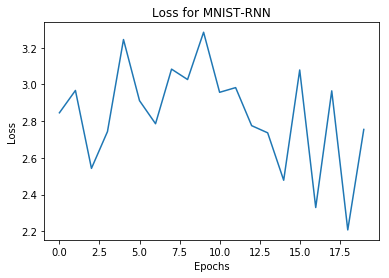

In [8]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size)).cuda()
    labels = Variable(labels).cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MNIST-RNN')
plt.show()